In [90]:
using Monkeypox
using Optim
using Optimization
using Plots
using Turing
using StatsPlots
using BSON: @save, @load
using BSON
using AxisArrays
using DifferentialEquations
using DifferentialEquations.EnsembleAnalysis
using Dates
#color = colorant"#bcafcf"
palette(:Paired_10)
pyplot()
countryarray = ["United States", "Spain", "Germany", "United Kingdom", "France", "Brazil", "Canada", "Netherlands"]
poparray = [329500000.0, 47350000.0, 83240000.0, 55980000.0, 67390000.0, 212600000.0, 38010000.0, 17440000.0]
url = "./data/timeseries-country-confirmed.csv";
function computedaily!(acc)
    mid = zeros(length(acc))
    mid[2:end] = acc[1:end-1]
    pred_daily = acc - mid
    return pred_daily
end
function computedailycontrol!(acc)
    pred_daily = acc[2:end] - acc[1:end-1]
    return pred_daily
end
function plotsim!(sim, color, linecolor, markercolor, datadate, datatspan, i, country, acc, cases)
    accmean = timeseries_steps_mean(sim)[10, :]
    dailymean = computedaily!(accmean)
    accup = timeseries_steps_quantile(sim, 0.95)[10, :]
    dailyup = computedaily!(accup)
    acclow = timeseries_steps_quantile(sim, 0.05)[10, :]
    dailylow = computedaily!(acclow)
    plot(datadate, accmean[datatspan], lw=3, linecolor=linecolor, color=color, ribbon=(acclow, accup), fillalpha=0.5, label="Predicted daily cases", legend_background_color=nothing, title=country)
    display(scatter!(datadate, acc[datatspan], markercolor=markercolor, label="Observed acculated cases"))
    savefig("./output/controlacc$i.png")
    plot(datadate, dailymean[datatspan], lw=3, linecolor=linecolor, color=color, ribbon=(dailylow, dailyup), fillalpha=0.5, label="Predicted daily cases", legend_background_color=nothing, title=country)
    display(scatter!(datadate, cases[datatspan], markercolor=markercolor, label="Observed daily cases"))
    savefig("./output/controldaily$i.png")
end
function dateall!(preddays, data_on)
    dateall = data_on.Date[1]:Day(1):(data_on.Date[end]+Day(preddays))
    return dateall
end
function datepredict!(preddays, data_on)
    datepredict = data_on.Date[end]:Day(1):(data_on.Date[end]+Day(preddays))
    return datepredict
end
function controlplotsim!(sim, controlsim, preddays, color, linecolor, markercolor, datadate, datatspan, i, country, acc, cases)
    accmean = [timeseries_steps_mean(sim)[10, :]; timeseries_steps_mean(controlsim)[10, 2:end]]
    dailymean = computedaily!(accmean)
    accup = [timeseries_steps_quantile(sim, 0.95)[10, :]; timeseries_steps_quantile(controlsim, 0.95)[10, 2:end]]
    dailyup = computedaily!(accup)
    acclow = [timeseries_steps_quantile(sim, 0.05)[10, :]; timeseries_steps_quantile(controlsim, 0.05)[10, 2:end]]
    dailylow = computedaily!(acclow)
    dateall = dateall!(preddays, data_on)
    plot(dateall, accmean, lw=3, linecolor=linecolor, color=color, ribbon=(acclow, accup), fillalpha=0.3, label="Predicted daily cases", legend_background_color=nothing, title=country)
    display(scatter!(datadate, acc[datatspan], markercolor=markercolor, label="Observed acculated cases"))
    savefig("./output/senocontrolacc$i.png")
    plot(dateall, dailymean, lw=3, linecolor=linecolor, color=color, ribbon=(dailylow, dailyup), fillalpha=0.3, label="Predicted daily cases", legend_background_color=nothing, title=country)
    display(scatter!(datadate, cases[datatspan], markercolor=markercolor, label="Observed daily cases"))
    savefig("./output/senocontroldaily$i.png")
end
function siminference!(i, country, color, linecolor, markercolor)
    data_on, acc, cases, datatspan, datadate = datasource!(url, country)
    N = poparray[i] # population
    θ = [0.3, 0.3, 0.2, 0.1, 0.7, 0.01]# ρ,σ,h,α
    pknown = [0.0, 0.0, 1 / 30, 1.0] # B,μ,δ,ϕ
    @load "./output/chain$i.bson" chainout
    println(country, "data parameter:", chainout[2])
    chain_array = Array(chainout[1])
    prob_pred = controlmonkeypoxprob!(N, θ, acc, pknown)

    function prob_func(prob, i, repeat)
        B = pknown[1]
        μ = pknown[2]
        δ = pknown[3]
        ϕ = pknown[4]
        θ = chain_array[rand(1:2000), 2:7]
        p0 = [B, μ, θ[1], θ[2], θ[3], θ[4], δ, θ[5], ϕ]
        u0 = [N - 1.0, 1.0, 0.0, θ[6] * N, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        prob_pred_train = remake(prob, u0=u0, p=p0)
    end
    ensemble_prob = EnsembleProblem(prob_pred, prob_func=prob_func)
    sim = solve(ensemble_prob, Tsit5(), saveat=0:length(acc)-1, EnsembleThreads(), trajectories=1000)
    plotsim!(sim, color, linecolor, markercolor, datadate, datatspan, i, country, acc, cases)
end
## plotdata
function plotdata!(url, country, markercolor)
    data_on, acc, cases, datatspan, datadate = datasource!(url, country)
    p1 = scatter(datadate, acc[datatspan], markercolor=markercolor, label="Observed acculated cases", legend_background_color=nothing, title=country)
    p2 = scatter(datadate, cases[datatspan], markercolor=markercolor, label="Observed daily cases", legend_background_color=nothing, title=country)
    return p1, p2
end
## obtain sim
function solinference!(i, url, country)
    data_on, acc, cases, datatspan, datadate = datasource!(url, country)
    outdate = data_on.Date
    N = poparray[i] # population
    θ = [0.3, 0.3, 0.2, 0.1, 0.7, 0.01]# ρ,σ,h,α
    pknown = [0.0, 0.0, 1 / 30, 1.0] # B,μ,δ,ϕ
    @load "./output/chain$i.bson" chainout
    println(country, "data parameter:", chainout[2])
    chain_array = Array(chainout[1])
    prob_pred = controlmonkeypoxprob!(N, θ, acc, pknown)
    function prob_func(prob, i, repeat)
        B = pknown[1]
        μ = pknown[2]
        δ = pknown[3]
        ϕ = pknown[4]
        θ = chain_array[rand(1:2000), 2:7]
        p0 = [B, μ, θ[1], θ[2], θ[3], θ[4], δ, θ[5], ϕ]
        u0 = [N - 1.0, 1.0, 0.0, θ[6] * N, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        prob_pred_train = remake(prob, u0=u0, p=p0)
    end
    ensemble_prob = EnsembleProblem(prob_pred, prob_func=prob_func)
    sim = solve(ensemble_prob, Tsit5(), saveat=0:length(acc)-1, EnsembleThreads(), trajectories=1000)
    return sim, outdate
end

## Obtain controlsim
function solcontrolinference!(sim, i, url, country, preddays, controlρ, controlσ, controlh, controlSS)
    data_on, acc, cases, datatspan, datadate = datasource!(url, country)
    outputdate = datepredict!(preddays, data_on)
    N = poparray[i] # population
    θ = [0.3, 0.3, 0.2, 0.1, 0.7, 0.01]# ρ,σ,h,α
    pknown = [0.0, 0.0, 1 / 30, 1.0] # B,μ,δ,ϕ
    @load "./output/chain$i.bson" chainout
    println(country, "data parameter:", chainout[2])
    chain_array = Array(chainout[1])
    prob_pred = controlmonkeypoxprob!(N, θ, acc, pknown)
    controlu0 = timeseries_steps_mean(sim)[:, end]
    function control_prob_func(prob, i, repeat)
        B = pknown[1]
        μ = pknown[2]
        δ = pknown[3]
        ϕ = pknown[4]
        θ = chain_array[rand(1:2000), 2:7]
        p0 = [B, μ, controlρ * θ[1], controlρ * θ[2], θ[3], controlσ *θ[4], δ, controlh * θ[5], ϕ]
        u0 = copy(controlu0)
        u0[4] = controlSS * u0[4]
        prob_pred_train = remake(prob, u0=u0, p=p0, tspan=(length(acc) - 1, length(acc) - 1 + preddays))
    end
    control_ensemble_prob = EnsembleProblem(prob_pred, prob_func=control_prob_func)
    controlsim = solve(control_ensemble_prob, Tsit5(), saveat=(length(acc)-1):(length(acc)-1+preddays), EnsembleThreads(), trajectories=1000)
    return controlsim, outputdate, controlρ, controlσ, controlh, controlSS
end

## integrated
function controlsiminference!(i, url, country, color, linecolor, markercolor, preddays, controlρ, controlσ, controlh, controlSS)
    data_on, acc, cases, datatspan, datadate = datasource!(url, country)
    N = poparray[i] # population
    θ = [0.3, 0.3, 0.2, 0.1, 0.7, 0.01]# ρ,σ,h,α
    pknown = [0.0, 0.0, 1 / 30, 1.0] # B,μ,δ,ϕ
    @load "./output/chain$i.bson" chainout
    println(country, "data parameter:", chainout[2])
    chain_array = Array(chainout[1])
    prob_pred = controlmonkeypoxprob!(N, θ, acc, pknown)
    function prob_func(prob, i, repeat)
        B = pknown[1]
        μ = pknown[2]
        δ = pknown[3]
        ϕ = pknown[4]
        θ = chain_array[rand(1:2000), 2:7]
        p0 = [B, μ, θ[1], θ[2], θ[3], θ[4], δ, θ[5], ϕ]
        u0 = [N - 1.0, 1.0, 0.0, θ[6] * N, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        prob_pred_train = remake(prob, u0=u0, p=p0)
    end
    ensemble_prob = EnsembleProblem(prob_pred, prob_func=prob_func)
    sim = solve(ensemble_prob, Tsit5(), saveat=0:length(acc)-1, EnsembleThreads(), trajectories=1000)
    controlu0 = timeseries_steps_mean(sim)[:, end]
    function control_prob_func(prob, i, repeat)
        B = pknown[1]
        μ = pknown[2]
        δ = pknown[3]
        ϕ = pknown[4]
        θ = chain_array[rand(1:2000), 2:7]
        p0 = [B, μ, controlρ * θ[1], controlρ * θ[2], θ[3], controlσ *θ[4], δ, controlh * θ[5], ϕ]
        u0 = copy(controlu0)
        u0[4] = controlSS * u0[4]
        prob_pred_train = remake(prob, u0=u0, p=p0, tspan=(length(acc) - 1, length(acc) - 1 + preddays))
    end
    control_ensemble_prob = EnsembleProblem(prob_pred, prob_func=control_prob_func)
    controlsim = solve(control_ensemble_prob, Tsit5(), saveat=(length(acc)-1):(length(acc)-1+preddays), EnsembleThreads(), trajectories=1000)
    controlplotsim!(sim, controlsim, preddays, color, linecolor, markercolor, datadate, datatspan, i, country, acc, cases)
end
function simopt!(i, country, color, linecolor, markercolor)
    data_on, acc, cases, datatspan, datadate = datasource!(url, country)
    N = poparray[i] # population
    θ = [0.3, 0.3, 0.2, 0.1, 0.7, 0.01]# ρ,σ,h,α
    pknown = [0.0, 0.0, 1 / 30, 1.0] # B,μ,δ,ϕ
    @load "./output/pmin$i.bson" p_min
    println(country, "data parameter:", p_min)
    prob_pred = controlmonkeypoxprob!(N, θ, acc, pknown)
    function prob_func(prob, i, repeat)
        B = pknown[1]
        μ = pknown[2]
        δ = pknown[3]
        ϕ = pknown[4]
        randnum = 1.0 + 0.2 * randn()
        θ = p_min
        p0 = [B, μ, randnum * θ[1], randnum * θ[2], randnum * θ[3], θ[4], δ, θ[5], ϕ]
        u0 = [N - 1.0, 1.0, 0.0, θ[6] * N, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        prob_pred_train = remake(prob, u0=u0, p=p0)
    end
    ensemble_prob = EnsembleProblem(prob_pred, prob_func=prob_func)
    sim = solve(ensemble_prob, Tsit5(), saveat=0:length(acc)-1, EnsembleThreads(), trajectories=1000)
    plotsim!(sim, color, linecolor, markercolor, datadate, datatspan, i, country, acc, cases)
end

## obtain sim opt
function solopt!(i, url,country)
    data_on, acc, cases, datatspan, datadate = datasource!(url, country)
    outdate = data_on.Date
    N = poparray[i] # population
    θ = [0.3, 0.3, 0.2, 0.1, 0.7, 0.01]# ρ,σ,h,α
    pknown = [0.0, 0.0, 1 / 30, 1.0] # B,μ,δ,ϕ
    @load "./output/pmin$i.bson" p_min
    println(country, "data parameter:", p_min)
    prob_pred = controlmonkeypoxprob!(N, θ, acc, pknown)
    function prob_func(prob, i, repeat)
        B = pknown[1]
        μ = pknown[2]
        δ = pknown[3]
        ϕ = pknown[4]
        randnum = 1.0 + 0.2 * randn()
        θ = p_min
        p0 = [B, μ, randnum * θ[1], randnum * θ[2], randnum * θ[3], θ[4], δ, θ[5], ϕ]
        u0 = [N - 1.0, 1.0, 0.0, θ[6] * N, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        prob_pred_train = remake(prob, u0=u0, p=p0)
    end
    ensemble_prob = EnsembleProblem(prob_pred, prob_func=prob_func)
    sim = solve(ensemble_prob, Tsit5(), saveat=0:length(acc)-1, EnsembleThreads(), trajectories=1000)
    return sim, outdate
end

## Obtain controlsim, opt version
function solcontrolopt!(sim, i, url, country, preddays, controlρ, controlσ, controlh, controlSS)
    data_on, acc, cases, datatspan, datadate = datasource!(url, country)
    outputdate = datepredict!(preddays, data_on)
    N = poparray[i] # population
    θ = [0.3, 0.3, 0.2, 0.1, 0.7, 0.01]# ρ,σ,h,α
    pknown = [0.0, 0.0, 1 / 30, 1.0] # B,μ,δ,ϕ
    @load "./output/pmin$i.bson" p_min
    println(country, "data parameter:", p_min)
    prob_pred = controlmonkeypoxprob!(N, θ, acc, pknown)
    controlu0 = timeseries_steps_mean(sim)[:, end]
    function control_prob_func(prob, i, repeat)
        B = pknown[1]
        μ = pknown[2]
        δ = pknown[3]
        ϕ = pknown[4]
        randnum = 1.0 + 0.2 * randn()
        θ = p_min
        p0 = [B, μ, randnum*controlρ * θ[1], randnum*controlρ * θ[2], randnum * θ[3], controlσ*θ[4], δ, controlh * θ[5], ϕ]
        u0 = copy(controlu0)
        u0[4] = controlSS * u0[4]
        prob_pred_train = remake(prob, u0=u0, p=p0, tspan=(length(acc) - 1, length(acc) - 1 + preddays))
    end
    control_ensemble_prob = EnsembleProblem(prob_pred, prob_func=control_prob_func)
    controlsim = solve(control_ensemble_prob, Tsit5(), saveat=(length(acc)-1):(length(acc)-1+preddays), EnsembleThreads(), trajectories=1000)
    return controlsim, outputdate, controlρ, controlσ, controlh, controlSS
end

function senarioplot!(sol, controlsol, preddays, color, linecolor, markercolor, datadate, datatspan, i, country, acc, cases)
    sim, simdate = sol
    accmean = timeseries_steps_mean(sim)[10, :]
    dailymean = computedaily!(accmean)
    accup = timeseries_steps_quantile(sim, 0.95)[10, :]
    dailyup = computedaily!(accup)
    acclow = timeseries_steps_quantile(sim, 0.05)[10, :]
    dailylow = computedaily!(acclow)
    ## Accumulated cases
    scatter(datadate, acc[datatspan], markercolor=markercolor, label="Observed acculated cases", legend_background_color=nothing, title=country)
    plot!(simdate, accmean, lw=3, linecolor=linecolor, color=color, ribbon=(acclow, accup), fillalpha=0.3, label="Predicted accumulated cases", legend_background_color=nothing, title=country)
    for case in 1:length(controlsol)
        controlsim, controldate = controlsol[case]
        controlaccmean = timeseries_steps_mean(controlsim)[10, :]
        #controldailymean = computedailycontrol!(controlaccmean)
        controlaccup = timeseries_steps_quantile(controlsim, 0.95)[10, :]
        #controldailyup = computedailycontrol!(controlaccup)
        controlacclow = timeseries_steps_quantile(controlsim, 0.05)[10, :]
        #controldailylow = computedailycontrol!(controlacclow)
        plot!(controldate, controlaccmean, lw=3, ribbon=(controlacclow, controlaccup), fillalpha=0.3, label="Forecasting accumulated cases", legend_background_color=nothing, title=country)
    end
    savefig("./output/senocontrolacc$i.png")
    ## daily
    scatter(datadate, cases[datatspan], markercolor=markercolor, label="Observed daily cases", legend_background_color=nothing, title=country)
    plot!(simdate, dailymean, lw=3, linecolor=linecolor, color=color, ribbon=(dailylow, dailyup), fillalpha=0.3, label="Predicted daily cases", legend_background_color=nothing, title=country)
    for case in 1:length(controlsol)
        controlsim, controldate, controlρ, controlσ, controlh, controlSS = controlsol[case]
        controlaccmean = timeseries_steps_mean(controlsim)[10, :]
        controldailymean = computedailycontrol!(controlaccmean)
        controlaccup = timeseries_steps_quantile(controlsim, 0.95)[10, :]
        controldailyup = computedailycontrol!(controlaccup)
        controlacclow = timeseries_steps_quantile(controlsim, 0.05)[10, :]
        controldailylow = computedailycontrol!(controlacclow)
        plot!(controldate[2:end], controldailymean, lw=3, ribbon=(controldailylow, controldailyup), fillalpha=0.3, label="Forecasting daily cases,$controlρ ρ $controlσ σ $controlh h", legend_background_color=nothing, title=country)
    end
    savefig("./output/senocontroldaily$i.png")
end

senarioplot! (generic function with 1 method)

In [91]:
i = 1
country = countryarray[i]
url = "./data/timeseries-country-confirmed.csv";
color = :cornflowerblue
linecolor = :darkturquoise
markercolor = :darksalmon
preddays = 60
controlρ = [0.9, 0.8, 0.7, 0.6, 0.5, 0.3, 0.2]
controlσ = 1.0
controlh = 1.0
controlSS = 1.0
sol = solinference!(i, url, country)
controlsol1 = solcontrolinference!(sim, i, url, country, preddays, controlρ[1], controlσ, controlh, controlSS)
controlsol2 = solcontrolinference!(sim, i, url, country, preddays, controlρ[2], controlσ, controlh, controlSS)
controlsol3 = solcontrolinference!(sim, i, url, country, preddays, controlρ[3], controlσ, controlh, controlSS)
controlsol4 = solcontrolinference!(sim, i, url, country, preddays, controlρ[4], controlσ, controlh, controlSS)
controlsol5 = solcontrolinference!(sim, i, url, country, preddays, controlρ[5], controlσ, controlh, controlSS)
controlsol6 = solcontrolinference!(sim, i, url, country, preddays, controlρ[6], controlσ, controlh, controlSS)
controlsol = (controlsol1, controlsol2, controlsol3, controlsol4, controlsol5, controlsol6)
senarioplot!(sol, controlsol, preddays, color, linecolor, markercolor, datadate, datatspan, i, country, acc, cases)

United Statesdata parameter:[0.15743588681151713, 0.9180733164763454, 0.023952871158225402, 0.20173132306604732, 0.8004600875418408, 0.09998943397765432]

United Statesdata parameter:[0.15743588681151713, 0.9180733164763454, 0.023952871158225402, 0.20173132306604732, 0.8004600875418408, 0.09998943397765432]


United Statesdata parameter:[0.15743588681151713, 0.9180733164763454, 0.023952871158225402, 0.20173132306604732, 0.8004600875418408, 0.09998943397765432]
United Statesdata parameter:[0.15743588681151713, 0.9180733164763454, 0.023952871158225402, 0.20173132306604732, 0.8004600875418408, 0.09998943397765432]
United Statesdata parameter:[0.15743588681151713, 0.9180733164763454, 0.023952871158225402, 0.20173132306604732, 0.8004600875418408, 0.09998943397765432]
United Statesdata parameter:[0.15743588681151713, 0.9180733164763454, 0.023952871158225402, 0.20173132306604732, 0.8004600875418408, 0.09998943397765432]


United Statesdata parameter:[0.15743588681151713, 0.9180733164763454, 0.023952871158225402, 0.20173132306604732, 0.8004600875418408, 0.09998943397765432]


In [93]:
for i in 1:length(countryarray)
    if i>1
    country = countryarray[i]
    url = "./data/timeseries-country-confirmed.csv";
    color = :cornflowerblue
    linecolor = :darkturquoise
    markercolor = :darksalmon
    preddays = 60
    controlρ = [0.9, 0.8, 0.7, 0.6, 0.5, 0.3, 0.2]
    controlσ = 1.0
    controlh = 1.0
    controlSS = 1.0
    sol = solopt!(i, url, country)
    controlsol1 = solcontrolopt!(sim, i, url, country, preddays, controlρ[1], controlσ, controlh, controlSS)
    controlsol2 = solcontrolopt!(sim, i, url, country, preddays, controlρ[2], controlσ, controlh, controlSS)
    controlsol3 = solcontrolopt!(sim, i, url, country, preddays, controlρ[3], controlσ, controlh, controlSS)
    controlsol4 = solcontrolopt!(sim, i, url, country, preddays, controlρ[4], controlσ, controlh, controlSS)
    controlsol5 = solcontrolopt!(sim, i, url, country, preddays, controlρ[5], controlσ, controlh, controlSS)
    controlsol6 = solcontrolopt!(sim, i, url, country, preddays, controlρ[6], controlσ, controlh, controlSS)
    controlsol = (controlsol1, controlsol2, controlsol3, controlsol4, controlsol5, controlsol6)
    senarioplot!(sol, controlsol, preddays, color, linecolor, markercolor, datadate, datatspan, i, country, acc, cases)
    end
end

Spaindata parameter:[0.07037834199615545, 0.9999999997643233, 0.10627015785351182, 0.9999999998777888, 0.9999999999830524, 0.09999996474529656]


Spaindata parameter:[0.07037834199615545, 0.9999999997643233, 0.10627015785351182, 0.9999999998777888, 0.9999999999830524, 0.09999996474529656]
Spaindata parameter:[0.07037834199615545, 0.9999999997643233, 0.10627015785351182, 0.9999999998777888, 0.9999999999830524, 0.09999996474529656]
Spaindata parameter:[0.07037834199615545, 0.9999999997643233, 0.10627015785351182, 0.9999999998777888, 0.9999999999830524, 0.09999996474529656]


Spaindata parameter:[0.07037834199615545, 0.9999999997643233, 0.10627015785351182, 0.9999999998777888, 0.9999999999830524, 0.09999996474529656]
Spaindata parameter:[0.07037834199615545, 0.9999999997643233, 0.10627015785351182, 0.9999999998777888, 0.9999999999830524, 0.09999996474529656]
Spaindata parameter:[0.07037834199615545, 0.9999999997643233, 0.10627015785351182, 0.9999999998777888, 0.9999999999830524, 0.09999996474529656]


Germanydata parameter:[0.027910159968183558, 0.8182266790069681, 0.053206982909098234, 0.5151774797542613, 0.9999989079427897, 0.09999834947563271]
Germanydata parameter:[0.027910159968183558, 0.8182266790069681, 0.053206982909098234, 0.5151774797542613, 0.9999989079427897, 0.09999834947563271]


Germanydata parameter:[0.027910159968183558, 0.8182266790069681, 0.053206982909098234, 0.5151774797542613, 0.9999989079427897, 0.09999834947563271]
Germanydata parameter:[0.027910159968183558, 0.8182266790069681, 0.053206982909098234, 0.5151774797542613, 0.9999989079427897, 0.09999834947563271]
Germanydata parameter:[0.027910159968183558, 0.8182266790069681, 0.053206982909098234, 0.5151774797542613, 0.9999989079427897, 0.09999834947563271]


Germanydata parameter:[0.027910159968183558, 0.8182266790069681, 0.053206982909098234, 0.5151774797542613, 0.9999989079427897, 0.09999834947563271]
Germanydata parameter:[0.027910159968183558, 0.8182266790069681, 0.053206982909098234, 0.5151774797542613, 0.9999989079427897, 0.09999834947563271]


United Kingdomdata parameter:[0.00010000006682928728, 0.4793152635898873, 0.030648921590233264, 0.7835827890487993, 0.83239465547756, 0.0018012751593155453]
United Kingdomdata parameter:[0.00010000006682928728, 0.4793152635898873, 0.030648921590233264, 0.7835827890487993, 0.83239465547756, 0.0018012751593155453]
United Kingdomdata parameter:[0.00010000006682928728, 0.4793152635898873, 0.030648921590233264, 0.7835827890487993, 0.83239465547756, 0.0018012751593155453]
United Kingdomdata parameter:[0.00010000006682928728, 0.4793152635898873, 0.030648921590233264, 0.7835827890487993, 0.83239465547756, 0.0018012751593155453]


United Kingdomdata parameter:[0.00010000006682928728, 0.4793152635898873, 0.030648921590233264, 0.7835827890487993, 0.83239465547756, 0.0018012751593155453]
United Kingdomdata parameter:[0.00010000006682928728, 0.4793152635898873, 0.030648921590233264, 0.7835827890487993, 0.83239465547756, 0.0018012751593155453]
United Kingdomdata parameter:[0.00010000006682928728, 0.4793152635898873, 0.030648921590233264, 0.7835827890487993, 0.83239465547756, 0.0018012751593155453]


Francedata parameter:[0.06204616003851901, 0.5873696153926592, 0.04911181088899285, 0.7268600660940907, 0.7725441036093287, 0.0019274144460322482]
Francedata parameter:[0.06204616003851901, 0.5873696153926592, 0.04911181088899285, 0.7268600660940907, 0.7725441036093287, 0.0019274144460322482]
Francedata parameter:[0.06204616003851901, 0.5873696153926592, 0.04911181088899285, 0.7268600660940907, 0.7725441036093287, 0.0019274144460322482]
Francedata parameter:[0.06204616003851901, 0.5873696153926592, 0.04911181088899285, 0.7268600660940907, 0.7725441036093287, 0.0019274144460322482]


Francedata parameter:[0.06204616003851901, 0.5873696153926592, 0.04911181088899285, 0.7268600660940907, 0.7725441036093287, 0.0019274144460322482]
Francedata parameter:[0.06204616003851901, 0.5873696153926592, 0.04911181088899285, 0.7268600660940907, 0.7725441036093287, 0.0019274144460322482]
Francedata parameter:[0.06204616003851901, 0.5873696153926592, 0.04911181088899285, 0.7268600660940907, 0.7725441036093287, 0.0019274144460322482]


Brazildata parameter:[0.0001000017985416187, 0.4554555286797448, 0.014015822554858913, 0.502467694581634, 0.6956695525456146, 0.07205589637486792]
Brazildata parameter:[0.0001000017985416187, 0.4554555286797448, 0.014015822554858913, 0.502467694581634, 0.6956695525456146, 0.07205589637486792]
Brazildata parameter:[0.0001000017985416187, 0.4554555286797448, 0.014015822554858913, 0.502467694581634, 0.6956695525456146, 0.07205589637486792]
Brazildata parameter:[0.0001000017985416187, 0.4554555286797448, 0.014015822554858913, 0.502467694581634, 0.6956695525456146, 0.07205589637486792]


Brazildata parameter:[0.0001000017985416187, 0.4554555286797448, 0.014015822554858913, 0.502467694581634, 0.6956695525456146, 0.07205589637486792]
Brazildata parameter:[0.0001000017985416187, 0.4554555286797448, 0.014015822554858913, 0.502467694581634, 0.6956695525456146, 0.07205589637486792]
Brazildata parameter:[0.0001000017985416187, 0.4554555286797448, 0.014015822554858913, 0.502467694581634, 0.6956695525456146, 0.07205589637486792]


Canadadata parameter:[0.06614710243423637, 0.9999999998624296, 0.15347027882113595, 0.9999999999908908, 0.9999999997000528, 0.03846681711556564]
Canadadata parameter:[0.06614710243423637, 0.9999999998624296, 0.15347027882113595, 0.9999999999908908, 0.9999999997000528, 0.03846681711556564]


Canadadata parameter:[0.06614710243423637, 0.9999999998624296, 0.15347027882113595, 0.9999999999908908, 0.9999999997000528, 0.03846681711556564]
Canadadata parameter:[0.06614710243423637, 0.9999999998624296, 0.15347027882113595, 0.9999999999908908, 0.9999999997000528, 0.03846681711556564]
Canadadata parameter:[0.06614710243423637, 0.9999999998624296, 0.15347027882113595, 0.9999999999908908, 0.9999999997000528, 0.03846681711556564]
Canadadata parameter:[0.06614710243423637, 0.9999999998624296, 0.15347027882113595, 0.9999999999908908, 0.9999999997000528, 0.03846681711556564]


Canadadata parameter:[0.06614710243423637, 0.9999999998624296, 0.15347027882113595, 0.9999999999908908, 0.9999999997000528, 0.03846681711556564]


Netherlandsdata parameter:[0.07332507309103613, 0.6597955617001287, 0.11432565248627546, 0.9999995474736596, 0.9999994915533763, 0.09126767004377759]
Netherlandsdata parameter:[0.07332507309103613, 0.6597955617001287, 0.11432565248627546, 0.9999995474736596, 0.9999994915533763, 0.09126767004377759]
Netherlandsdata parameter:[0.07332507309103613, 0.6597955617001287, 0.11432565248627546, 0.9999995474736596, 0.9999994915533763, 0.09126767004377759]
Netherlandsdata parameter:[0.07332507309103613, 0.6597955617001287, 0.11432565248627546, 0.9999995474736596, 0.9999994915533763, 0.09126767004377759]


Netherlandsdata parameter:[0.07332507309103613, 0.6597955617001287, 0.11432565248627546, 0.9999995474736596, 0.9999994915533763, 0.09126767004377759]
Netherlandsdata parameter:[0.07332507309103613, 0.6597955617001287, 0.11432565248627546, 0.9999995474736596, 0.9999994915533763, 0.09126767004377759]
Netherlandsdata parameter:[0.07332507309103613, 0.6597955617001287, 0.11432565248627546, 0.9999995474736596, 0.9999994915533763, 0.09126767004377759]


United Statesdata parameter:[0.15743588681151713, 0.9180733164763454, 0.023952871158225402, 0.20173132306604732, 0.8004600875418408, 0.09998943397765432]


United Statesdata parameter:[0.15743588681151713, 0.9180733164763454, 0.023952871158225402, 0.20173132306604732, 0.8004600875418408, 0.09998943397765432]


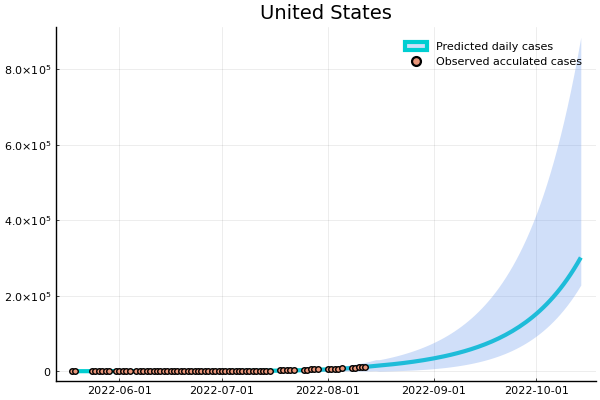

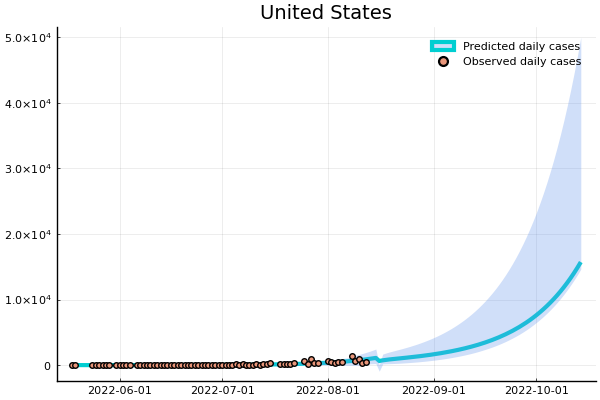

In [70]:
## single plot
i = 1
country = countryarray[i]
url = "./data/timeseries-country-confirmed.csv";
color = :cornflowerblue
linecolor = :darkturquoise
markercolor = :darksalmon
preddays = 60
controlρ = 0.5
controlσ = 1.0
controlh = 1.0
controlSS = 1.0
sim = solinference!(i, url, country)[1]
controlsim = solcontrolinference!(sim, i, url, country, preddays, controlρ, controlσ, controlh, controlSS)[1]
controlplotsim!(sim, controlsim, preddays, color, linecolor, markercolor, datadate, datatspan, i, country, acc, cases)

In [69]:
p1,p2=plotdata!(url, country,markercolor)
p3,p4=simplot!(sim, color, linecolor, datadate, i, country, pacc=p1, pdaily=p2)
plot(p3)


MethodError: MethodError: no method matching simplot!(::EnsembleSolution{Float64, 3, Vector{ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, SciMLBase.NullParameters, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Vector{Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, SciMLBase.NullParameters, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, SciMLBase.NullParameters, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, OrdinaryDiffEq.InterpolationData{ODEFunction{true, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, SciMLBase.NullParameters, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Vector{Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, SciMLBase.NullParameters, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, SciMLBase.NullParameters, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Vector{Vector{Float64}}}, OrdinaryDiffEq.Tsit5Cache{Vector{Float64}, Vector{Float64}, Vector{Float64}, OrdinaryDiffEq.Tsit5ConstantCache{Float64, Float64}, typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}}, DiffEqBase.DEStats}}}, ::Symbol, ::Symbol, ::Vector{Date}, ::Int64, ::String; pacc=Plot{Plots.PyPlotBackend() n=1}, pdaily=Plot{Plots.PyPlotBackend() n=1})
Closest candidates are:
  simplot!(::Any, ::Any, ::Any, ::Any, ::Any, ::Any) at f:\Code\Julia\Julia-1.6.2\jpkgs\.julia\dev\Monkeypox\reloadmultiplecontries.ipynb:98 got unsupported keyword arguments "pacc", "pdaily"
  simplot!(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any) at f:\Code\Julia\Julia-1.6.2\jpkgs\.julia\dev\Monkeypox\reloadmultiplecontries.ipynb:98 got unsupported keyword arguments "pacc", "pdaily"
  simplot!(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any, !Matched::Any) at f:\Code\Julia\Julia-1.6.2\jpkgs\.julia\dev\Monkeypox\reloadmultiplecontries.ipynb:98 got unsupported keyword arguments "pacc", "pdaily"

In [45]:
i = 1
country = countryarray[i]
url = "./data/timeseries-country-confirmed.csv";
color = :cornflowerblue
linecolor = :darkturquoise
markercolor = :darksalmon
preddays = 60
controlρ = 0.8
controlσ = 1.0
controlh = 1.0
controlSS = 1.0
data_on, acc, cases, datatspan, datadate = datasource!(url, country)
N = poparray[i] # population
θ = [0.3, 0.3, 0.2, 0.1, 0.7, 0.01]# ρ,σ,h,α
pknown = [0.0, 0.0, 1 / 30, 1.0] # B,μ,δ,ϕ
@load "./output/chain$i.bson" chainout
println(country, "data parameter:", chainout[2])
chain_array = Array(chainout[1])
prob_pred = controlmonkeypoxprob!(N, θ, acc, pknown)
function prob_func(prob, i, repeat)
    B = pknown[1]
    μ = pknown[2]
    δ = pknown[3]
    ϕ = pknown[4]
    θ = chain_array[rand(1:2000), 2:7]
    p0 = [B, μ, θ[1], θ[2], θ[3], θ[4], δ, θ[5], ϕ]
    u0 = [N - 1.0, 1.0, 0.0, θ[6] * N, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    prob_pred_train = remake(prob, u0=u0, p=p0)
end
ensemble_prob = EnsembleProblem(prob_pred, prob_func=prob_func)
sim = solve(ensemble_prob, Tsit5(), saveat=0:length(acc)-1, EnsembleThreads(), trajectories=1000)


United Statesdata parameter:[0.15743588681151713, 0.9180733164763454, 0.023952871158225402, 0.20173132306604732, 0.8004600875418408, 0.09998943397765432]

EnsembleSolution Solution of length 1000 with uType:
ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, SciMLBase.NullParameters, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Vector{Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEq

In [46]:
controlu0 = timeseries_steps_mean(sim)[:, end]
function control_prob_func(prob, i, repeat)
    B = pknown[1]
    μ = pknown[2]
    δ = pknown[3]
    ϕ = pknown[4]
    θ = chain_array[rand(1:2000), 2:7]
    p0 = [B, μ, controlρ * θ[1], controlρ * θ[2], controlσ * θ[3], θ[4], δ, controlh * θ[5], ϕ]
    u0 = copy(controlu0)
    u0[4] = controlSS * u0[4]
    prob_pred_train = remake(prob, u0=u0, p=p0, tspan=(length(acc) - 1, length(acc) - 1 + preddays))
end
control_ensemble_prob = EnsembleProblem(prob_pred, prob_func=control_prob_func)
controlsim = solve(control_ensemble_prob, Tsit5(), saveat=length(acc):(length(acc)-1+preddays), EnsembleThreads(), trajectories=1000)

EnsembleSolution Solution of length 1000 with uType:
ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, typeof(controlmonkeypoxpair!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, OrdinaryDiffEq.InterpolationData{ODEFunction{true, typeof(controlmonkeypoxpair!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Vector{Vector{Float64}}, Vec

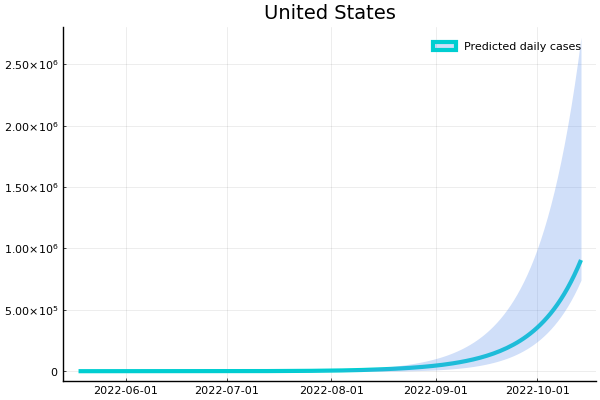

In [50]:
acclow = [timeseries_steps_quantile(sim, 0.05)[10, :]; timeseries_steps_quantile(controlsim, 0.05)[10, :]]
accmean = [timeseries_steps_mean(sim)[10, :]; timeseries_steps_mean(controlsim)[10, :]]
dailymean = computedaily!(accmean)
accup = [timeseries_steps_quantile(sim, 0.95)[10, :]; timeseries_steps_quantile(controlsim, 0.95)[10, :]]
dailyup = computedaily!(accup)
acclow = [timeseries_steps_quantile(sim, 0.05)[10, :]; timeseries_steps_quantile(controlsim, 0.05)[10, :]]
dailylow = computedaily!(acclow)
dateall = dateall!(preddays, data_on)
plot(dateall, accmean, lw=3, linecolor=linecolor, color=color, ribbon=(acclow, accup), fillalpha=0.3, label="Predicted daily cases", legend_background_color=nothing, title=country)


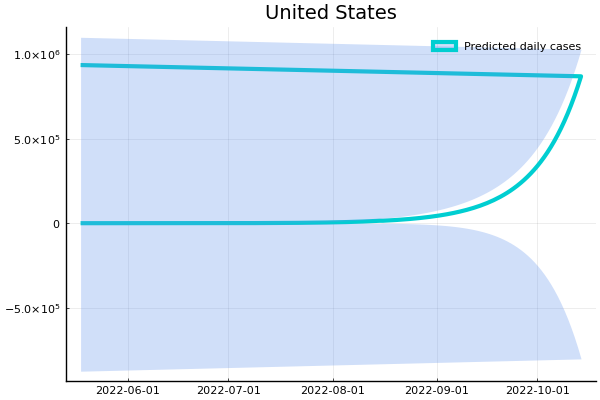

In [26]:
accmean = [timeseries_steps_mean(sim)[10, :];timeseries_steps_mean(controlsim)[10, :]]
dailymean = computedaily!(accmean)
accup = [timeseries_steps_quantile(sim, 0.95)[10, :];timeseries_steps_quantile(controlsim, 0.95)[10, :]]
dailyup = computedaily!(accup)
acclow = [timeseries_steps_quantile(sim, 0.05)[10, :];timeseries_steps_quantile(controlsim, 0.05)[10, :]]
dailylow = computedaily!(acclow)
dateall = dateall!(preddays,data_on)
plot(dateall, accmean, lw=3, linecolor=linecolor, color=color, ribbon=(accup, acclow), fillalpha=0.3, label="Predicted daily cases", legend_background_color=nothing, title=country)
display(scatter!(datadate, acc[datatspan], markercolor=markercolor, label="Observed acculated cases"))
savefig("./output/senocontrolacc$i.png")
plot(dateall, dailymean, lw=3, linecolor=linecolor, color=color, ribbon=(dailyup, dailylow), fillalpha=0.3, label="Predicted daily cases", legend_background_color=nothing, title=country)
display(scatter!(datadate, cases[datatspan], markercolor=markercolor, label="Observed daily cases"))
savefig("./output/senocontroldaily$i.png")

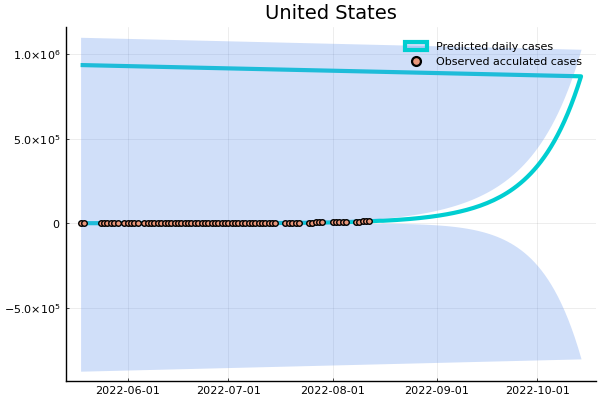

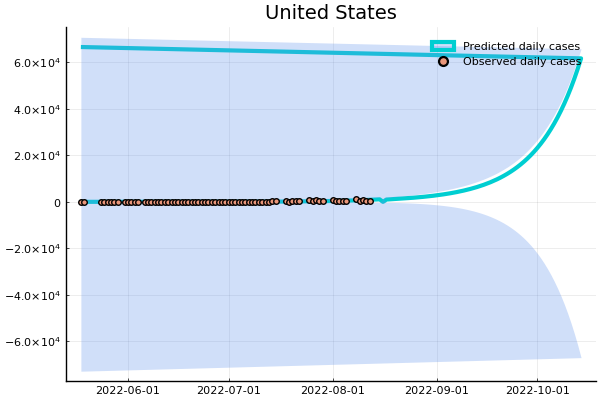

In [20]:
controlplotsim!(sim, controlsim,preddays, color, linecolor, markercolor, datadate, datatspan, i, country, acc, cases)

Spaindata parameter:[0.07037834199615545, 0.9999999997643233, 0.10627015785351182, 0.9999999998777888, 0.9999999999830524, 0.09999996474529656]


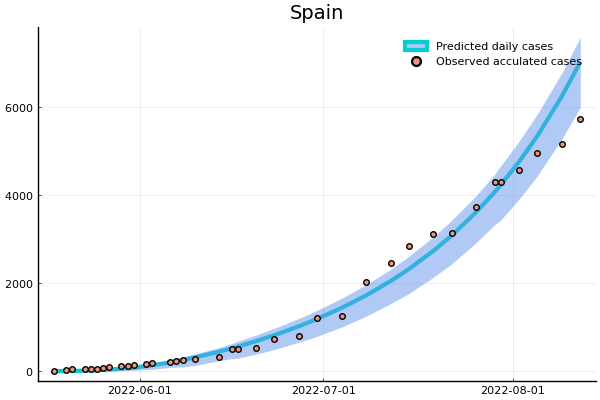

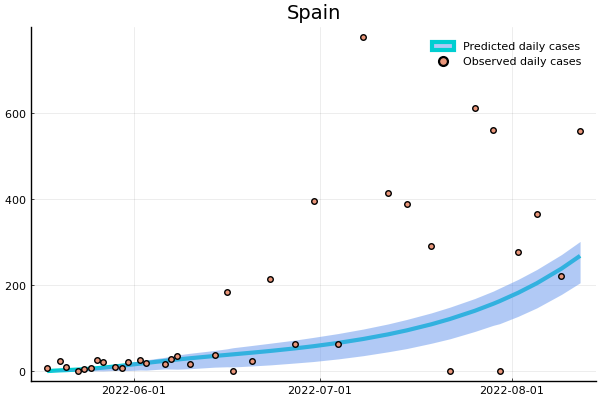

In [166]:
i=2
country = countryarray[i]
color = :cornflowerblue
linecolor = :darkturquoise
markercolor = :darksalmon
simopt!(i, country, color, linecolor, markercolor)


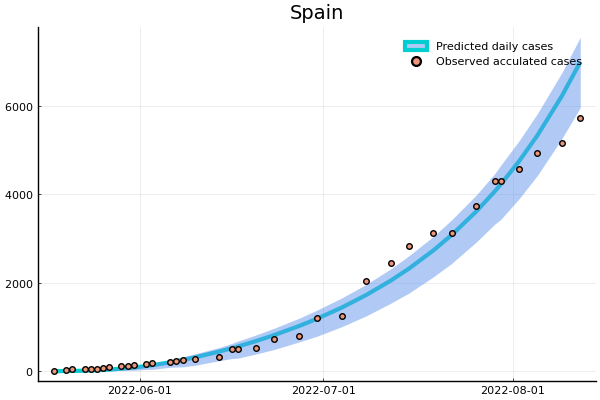

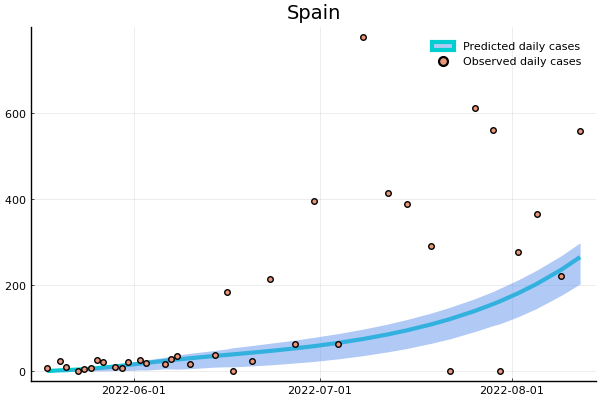

Spaindata parameter:[0.07037834199615545, 0.9999999997643233, 0.10627015785351182, 0.9999999998777888, 0.9999999999830524, 0.09999996474529656]


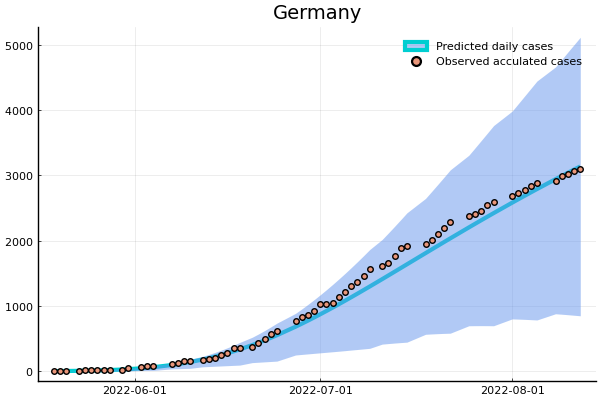

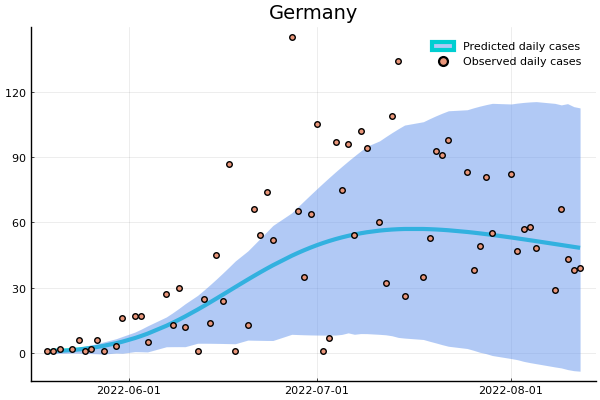

Germanydata parameter:[0.027910159968183558, 0.8182266790069681, 0.053206982909098234, 0.5151774797542613, 0.9999989079427897, 0.09999834947563271]


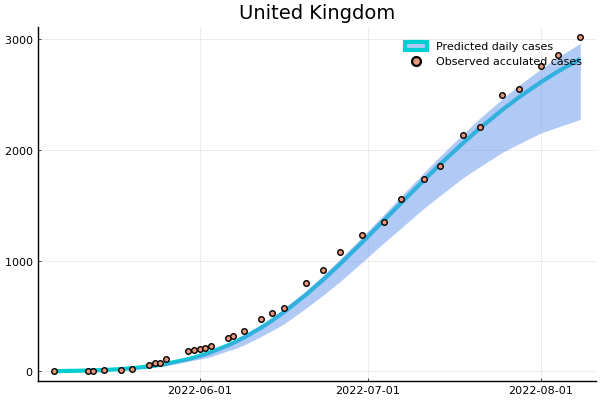

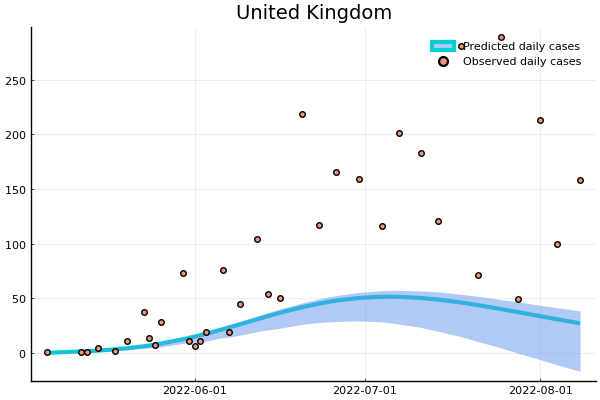

United Kingdomdata parameter:[0.00010000006682928728, 0.4793152635898873, 0.030648921590233264, 0.7835827890487993, 0.83239465547756, 0.0018012751593155453]


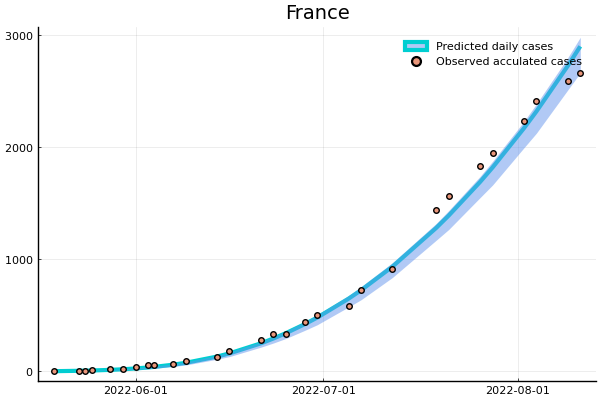

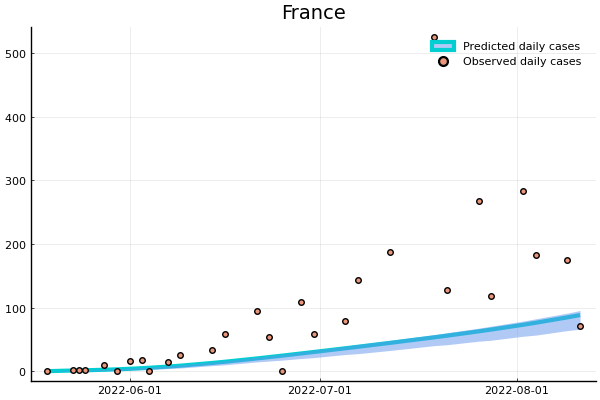

Francedata parameter:[0.06204616003851901, 0.5873696153926592, 0.04911181088899285, 0.7268600660940907, 0.7725441036093287, 0.0019274144460322482]


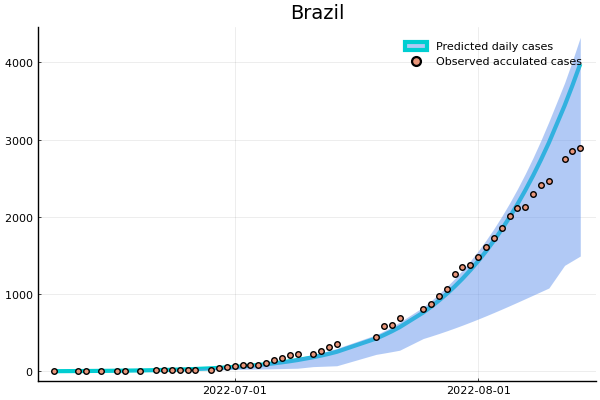

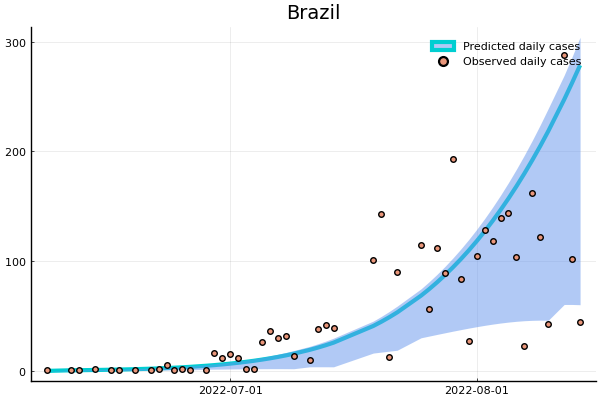

Brazildata parameter:[0.0001000017985416187, 0.4554555286797448, 0.014015822554858913, 0.502467694581634, 0.6956695525456146, 0.07205589637486792]


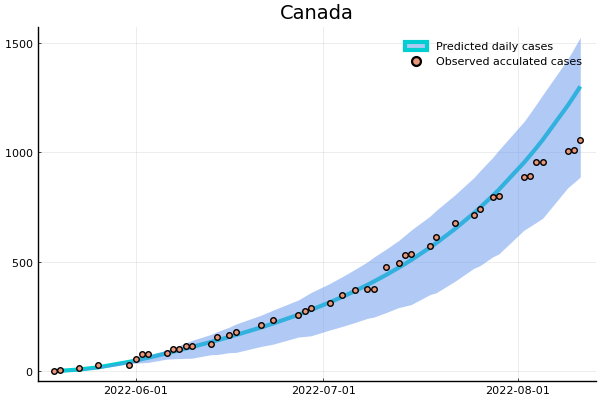

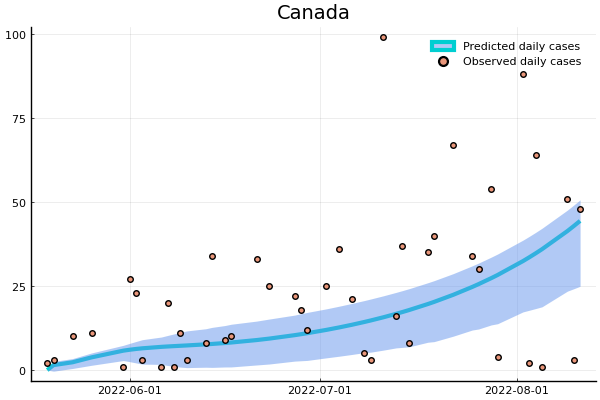

Canadadata parameter:[0.06614710243423637, 0.9999999998624296, 0.15347027882113595, 0.9999999999908908, 0.9999999997000528, 0.03846681711556564]


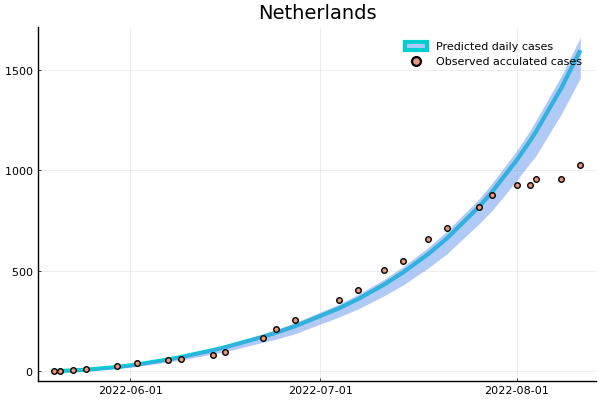

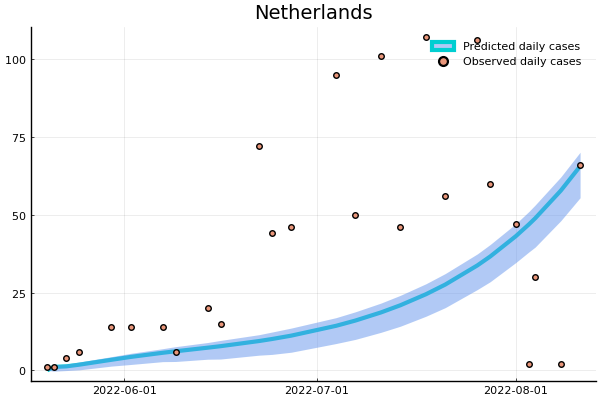

Netherlandsdata parameter:[0.07332507309103613, 0.6597955617001287, 0.11432565248627546, 0.9999995474736596, 0.9999994915533763, 0.09126767004377759]


In [167]:
for (i, country) in enumerate(countryarray)
    color = :cornflowerblue
    linecolor = :darkturquoise
    markercolor = :darksalmon
    if i>1
    simopt!(i, country, color, linecolor, markercolor)
    end
end